In [1]:
pwd

'/home/edison/Desktop/Bayesian'

In [2]:
ls

Bayesian.ipynb  finch_beaks_2012.csv*


In [182]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from ipywidgets import interact
import seaborn as sns

sns.set()
%matplotlib inline

In [241]:
import pymc3 as pm
import arviz as az
#import janitor
#import holoviews as hv
#import bokeh
#import hvplot.pandas

#hv.extension("bokeh")


#%load_ext autoreload
#%autoreload 2
#%config InlineBackend.figure_format = 'retina'

#sns.set_style('white')
#sns.set_context('talk')

## Starter

In [4]:
x = np.random.rand(1000)
x[:10]

array([0.44741112, 0.02634025, 0.57791271, 0.90214333, 0.42527064,
       0.65459064, 0.89773283, 0.15488883, 0.18467055, 0.83334632])

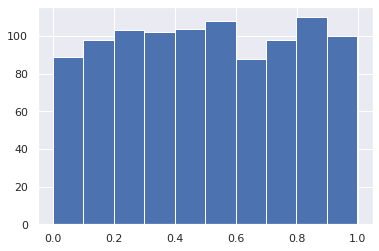

In [8]:
plt.hist(x)
plt.show()

### Fair Tossing

In [13]:
x[x <= 0.5].size

496

In [16]:
clicks = (x <= 0.5)
clicks[:10]

array([ True,  True, False, False,  True, False, False,  True,  True,
       False])

In [21]:
clicks.size

1000

In [19]:
num_clicks = sum(clicks)
num_clicks

496

In [24]:
print(f"The proportion of ppl that clicked is of: {num_clicks / x.size * 100}%")

The proportion of ppl that clicked is of: 49.6%


### Biased Tossing

In [25]:
clicks = (x <= 0.7)
clicks[:10]

array([ True,  True,  True, False,  True,  True, False,  True,  True,
       False])

In [27]:
num_clicks = sum(clicks)
num_clicks

693

In [28]:
print(f"The proportion of ppl that clicked is of: {num_clicks / x.size * 100}%")

The proportion of ppl that clicked is of: 69.3%


## Finch

In [63]:
df = pd.read_csv('finch_beaks_2012.csv')

In [64]:
df.head(3)

,band,species,blength,bdepth
0,19022,fortis,10.0,8.5
1,19028,fortis,12.5,8.9
2,19032,fortis,9.3,7.5


In [65]:
df.columns

Index(['band', 'species', 'blength', 'bdepth'], dtype='object')

In [67]:
df.shape

(249, 4)

In [34]:
df[df['blength'] > 10].shape

(212, 4)

In [46]:
print(f"The proportion of beaks' length gt 10 is of: \
{round(df[df['blength'] > 10].shape[0] / df.shape[0] *100, 2)}%")

The proportion of beaks' length gt 10 is of: 85.14%


In [47]:
lengths = df['blength']

In [50]:
lengths.shape

(249,)

In [54]:
statement = np.random.choice(lengths, n_samples, replace=True) > 10
statement

array([False,  True,  True, ...,  True,  True,  True])

In [55]:
statement.shape

(10000,)

In [57]:
statement_2 = np.random.choice(lengths, n_samples, replace=True)
statement_2

array([10.4, 10.1, 11.3, ..., 15. , 10.3, 12.5])

In [58]:
statement_2.shape

(10000,)

In [48]:
n_samples = 10000
sum(np.random.choice(lengths, n_samples, replace=True) > 10)/n_samples

0.8545

## Binomial

In [5]:
np.random.seed(seed = 16071982)

In [6]:
np.random.binomial(10, 0.7)               # 1 run of biased tossing 10 times with prob = 0.7

7

In [20]:
x = np.random.binomial(10, 0.3, 10000)        # 10000 run of tossing 10 times

In [27]:
x.shape

(10000,)

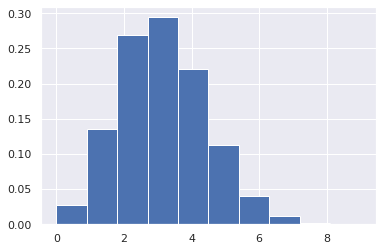

In [21]:
plt.hist(x, density = True, bins = 10)
plt.show()

In [23]:
sum((np.random.binomial(20, 0.3, 10000) >= 5)) / 10000

0.7738

In [25]:
sum((np.random.binomial(20, 0.5, 10000) >= 5)) / 10000

0.9929

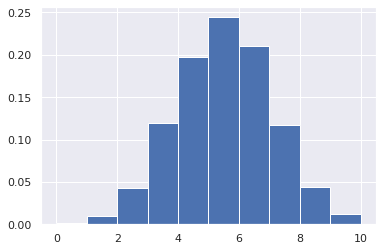

In [28]:
x = np.random.binomial(10, 0.5, 10000)
plt.hist(x, density = True, bins = 10);

It's pretty hard to see the probability of 4 or more heads just from the histogram

In [29]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)                      # Number of data points
    x = np.sort(data)                  # x-data for the ECDF
    y = np.arange(1, n + 1) / n          # y-data for the ECDF
    return x, y

In [30]:
x

array([5, 6, 4, ..., 5, 7, 4])

In [31]:
x.shape

(10000,)

In [32]:
x_flips, y_flips = ecdf(x)

In [33]:
x_flips

array([ 0,  0,  0, ..., 10, 10, 10])

In [37]:
y_flips

array([1.000e-04, 2.000e-04, 3.000e-04, ..., 9.998e-01, 9.999e-01,
       1.000e+00])

In [36]:
x_flips.shape, y_flips.shape

((10000,), (10000,))

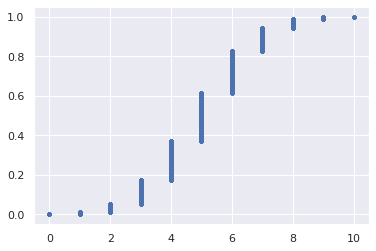

In [38]:
plt.plot(x_flips, y_flips, marker='.', linestyle='none')
plt.show()

## Poisson 

In the book *Information Theory, Inference and Learning Algorithms*, David MacKay tells the tale of a town called Poissonville, in which the buses have an odd schedule. Standing at a bus stop in Poissonville, the amount of time you have to wait for a bus is totally independent of when the previous bus arrived. This means you could watch a bus drive off and another arrive almost instantaneously, or you could be waiting for hours.

Arrival of buses in Poissonville is what we call a Poisson process. The timing of the next event is completely independent of when the previous event happened. Many real-life processes behave in this way:
1. natural births in a given hospital (there is a well-defined average number of natural births per year, and the timing of one birth is independent of the timing of the previous one);
2. Landings on a website;
3. Meteor strikes;
4. Molecular collisions in a gas;
5. Aviation incidents.

Any process that matches the buses in Poissonville story is a Poisson process.

 The Poisson distribution has one parameter, the average number of arrivals in a given length of time. So, to match the story, we could consider the number of hits on a website in an hour with an average of six hits per hour. This is Poisson distributed as demonstrated following:

In [40]:
poisson_samples  =  np.random.poisson(6, size = 10**6)
poisson_samples.shape

(1000000,)

In [46]:
np.random.choice(poisson_samples, 13)

array([6, 6, 6, 6, 4, 4, 7, 5, 7, 1, 8, 6, 5])

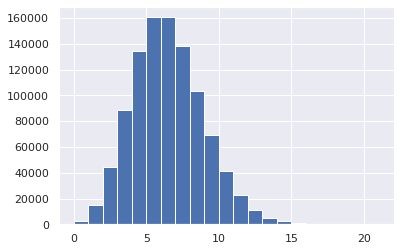

In [47]:
plt.hist(poisson_samples, bins = 21)
plt.show()

In [50]:
sum(poisson_samples[poisson_samples == 6]), poisson_samples.size

(962958, 1000000)

In [49]:
sum(poisson_samples[poisson_samples == 6]) / poisson_samples.size

0.962958

In fact, the Poisson distribution is the limit of the Binomial distribution for low probability of success and large number of trials, that is, for rare events.

To see this, think about the stories. Picture this: you're doing a Bernoulli trial once a minute for an hour, each with a success probability of 0.05. We would do 60 trials, and the number of successes is Binomially distributed, and we would expect to get about 3 successes. This is just like the Poisson story of seeing 3 buses on average arrive in a given interval of time. Thus the Poisson distribution with arrival rate equal to np approximates a Binomial distribution for n Bernoulli trials with probability p of success (with n large and p small). This is useful because the Poisson distribution can be simpler to work with as it has only one parameter instead of two for the Binomial distribution.

In [51]:
x_p, y_p = ecdf(poisson_samples)

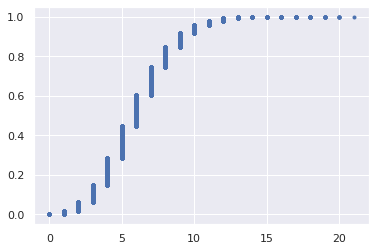

In [52]:
plt.plot(x_p, y_p, marker='.', linestyle='none')
plt.show()

In [53]:
fga = [19, 16, 15, 20, 20, 11, 15, 22, 34, 17, 20, 24, 14, 14, 
       24, 26, 14, 17, 20, 23, 16, 11, 22, 15, 18, 22, 23, 13, 
       18, 15, 23, 22, 23, 18, 17, 22, 17, 15, 23, 8, 16, 25, 
       18, 16, 17, 23, 17, 15, 20, 21, 10, 17, 22, 20, 20, 23, 
       17, 18, 16, 25, 25, 24, 19, 17, 25, 20, 20, 14, 25, 26, 
       29, 19, 16, 19, 18, 26, 24, 21, 14, 20, 29, 16, 9]

In [54]:
x_ecdf, y_ecdf = ecdf(fga)

In [56]:
x_ecdf.size, y_ecdf.size

(83, 83)

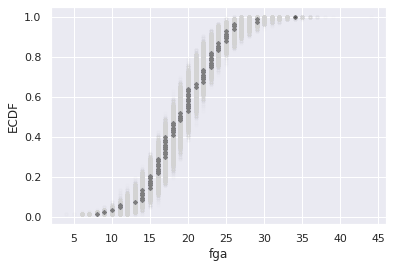

In [58]:
n_reps = 1000

plt.plot(x_ecdf, y_ecdf, '.', color='black')                          # ECDF of data

for _ in range(n_reps):                                               # Plot ECDF of model
    samples = np.random.poisson(np.mean(fga), size = len(fga))            
    x_theor, y_theor = ecdf(samples)
    plt.plot(x_theor, y_theor, '.', alpha = 0.01, color = 'lightgray');

plt.xlabel('fga')
plt.ylabel('ECDF')
plt.show()

## Exponential

To see what the story of the Exponential distribution is, let's return to Poissonville, in which the number of buses that will arrive per hour are Poisson distributed. However, the waiting time between arrivals of a Poisson process are exponentially distributed.

So: the exponential distribution has the following story: the waiting time between arrivals of a Poisson process are exponentially distributed. It has a single parameter, the mean waiting time.

For an illustrative example, lets check out the time between all incidents involving nuclear power since 1974. It's a reasonable first approximation to expect incidents to be well-modeled by a Poisson process, which means the timing of one incident is independent of all others. If this is the case, the time between incidents should be Exponentially distributed.

In [75]:
df = pd.read_csv('nuclear_power_accidents.csv')

In [76]:
df.head(3)

,Date,Location,Cost (millions 2013US$),INES,Smyth Magnitude,Region,Description,Fatalities
0,4/26/1986,"Kiev, Ukraine",259336.0,7.0,8.0,EE,Mishandled reactor safety test at Chernobyl nu...,4056
1,3/11/2011,"Fukushima Prefecture, Japan",166089.0,7.0,7.5,A,An earthquake and tsunami caused emergency bac...,573
2,12/8/1995,"Tsuruga, Japan",15500.0,NaN,NaN,A,Japan's only fast breeder reactor Monju suffer...,0


In [77]:
df.shape

(216, 8)

In [78]:
df.columns

Index(['Date', 'Location', 'Cost (millions 2013US$)', 'INES',
       'Smyth Magnitude', 'Region', 'Description', 'Fatalities'],
      dtype='object')

In [79]:
df['Date'] = pd.to_datetime(df['Date'])

In [80]:
df[df.Date >= pd.to_datetime('1974-01-01')]

,Date,Location,Cost (millions 2013US$),INES,Smyth Magnitude,Region,Description,Fatalities
0,1986-04-26,"Kiev, Ukraine",259336.0,7.0,8.0,EE,Mishandled reactor safety test at Chernobyl nu...,4056
1,2011-03-11,"Fukushima Prefecture, Japan",166089.0,7.0,7.5,A,An earthquake and tsunami caused emergency bac...,573
2,1995-12-08,"Tsuruga, Japan",15500.0,NaN,NaN,A,Japan's only fast breeder reactor Monju suffer...,0
3,1979-03-28,"Middletown, Pennsylvania, United States",10910.0,5.0,7.9,NaN,Equipment failure and operator error contribut...,0
6,1977-01-01,"Beloyarsk, USSR",3500.0,5.0,NaN,EE,"Unit 2 suffers a half core meltdown, repairs t...",0
...,...,...,...,...,...,...,...,...
211,1997-11-03,"Ibaraki Prefecture, Japan",NaN,3.0,NaN,A,At least 37 workers were expossed to elevated ...,0
212,1996-05-15,"Morris, Grundy County, Illinois, USA",NaN,NaN,NaN,NaN,Plunging water levels around the nuclear fuel ...,0
213,1978-03-11,"Pinawa, Manitoba, Canada",NaN,NaN,NaN,NaN,"The reactor which was cooled by a type of oil,...",0
214,1990-09-25,"Pickering, Canada",NaN,NaN,NaN,NaN,Pickering reactor 2 experienced large power sh...,0


In [81]:
df_reduced = df[df.Date >= pd.to_datetime('1974-01-01')]

In [83]:
df_reduced.tail(3)

,Date,Location,Cost (millions 2013US$),INES,Smyth Magnitude,Region,Description,Fatalities
213,1978-03-11,"Pinawa, Manitoba, Canada",NaN,NaN,NaN,NaN,"The reactor which was cooled by a type of oil,...",0
214,1990-09-25,"Pickering, Canada",NaN,NaN,NaN,NaN,Pickering reactor 2 experienced large power sh...,0
215,1992-08-02,"Pickering, Canada",NaN,NaN,NaN,NaN,Pickering reactor 4 had a heavy water leak fro...,0


In [91]:
np.sort(df_reduced['Date'])[:10]

array(['1974-10-31T00:00:00.000000000', '1975-02-06T00:00:00.000000000',
       '1975-03-22T00:00:00.000000000', '1975-11-05T00:00:00.000000000',
       '1975-11-30T00:00:00.000000000', '1975-12-07T00:00:00.000000000',
       '1976-01-05T00:00:00.000000000', '1977-01-01T00:00:00.000000000',
       '1977-02-22T00:00:00.000000000', '1977-06-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [92]:
np.sort(df_reduced['Date'])[:10].astype(float)

array([1.524096e+17, 1.608768e+17, 1.646784e+17, 1.843776e+17,
       1.865376e+17, 1.871424e+17, 1.896480e+17, 2.209248e+17,
       2.254176e+17, 2.347488e+17])

In [95]:
np.diff(np.sort(df_reduced['Date'])[:10].astype(float))

array([8.46720e+15, 3.80160e+15, 1.96992e+16, 2.16000e+15, 6.04800e+14,
       2.50560e+15, 3.12768e+16, 4.49280e+15, 9.33120e+15])

In [96]:
np.diff(np.sort(df_reduced['Date'])[:10].astype(float)) / 1e9 / 3600 / 24

array([ 98.,  44., 228.,  25.,   7.,  29., 362.,  52., 108.])

In [88]:
inter_times = np.diff(np.sort(df_reduced['Date'])).astype(float) / 1e9 / 3600 / 24
inter_times

array([ 98.,  44., 228.,  25.,   7.,  29., 362.,  52., 108., 274., 330.,
        52.,   0., 110.,   9.,  48.,   1., 183., 172.,  21.,  61.,  81.,
        25., 196.,  11., 148.,  22.,   5.,  85.,  83., 156.,  14.,  11.,
       145.,  37.,  16.,   0.,   3.,  36.,  39., 126.,   4.,  56.,  34.,
        60., 175.,  92.,   5.,  69., 118.,   8., 106.,  15.,   8.,  18.,
         0., 201., 124.,  22., 227.,   2.,  97.,   4.,  44.,   0.,  37.,
        84.,  73., 103.,  12., 177.,  29.,  46.,  25., 280., 137.,  53.,
       228., 156.,  22.,  46.,  35., 185.,  24.,   3.,  29.,   6., 263.,
       385.,  19., 103., 206.,  74.,  85., 110.,   3.,  15., 270.,  84.,
        55., 568.,  24., 103.,   1.,  88., 447., 147., 124.,  38.,   0.,
        26., 248.,  31.,  54.,  85., 223., 179.,  85., 253.,  12.,  46.,
        12.,  37., 204.,  10., 111., 182., 206., 322.,  30.,   0.,   9.,
        45., 200.,  87.,  24.,  39.,  15.,  96.,  62., 380.,  23.,   0.,
       165.,  20.,   9.,  28.,  63.,   1.,  39.,  4

In [97]:
mean = np.mean(inter_times)                                   # compute mean and sample from exponential

samples = np.random.exponential(mean, size = 10 ** 6)

In [98]:
x, y = ecdf(inter_times)                         # compute ECDFs for sample & model

In [99]:
x_theor, y_theor = ecdf(samples)

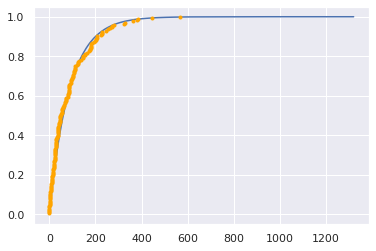

In [104]:
plt.plot(x_theor, y_theor)

plt.plot(x, y, marker = '.', color = 'orange', linestyle='none')

plt.show()

We see that the data is close to being Exponentially distributed, which means that we can model the nuclear incidents as a Poisson process.

## Normal

The Normal distribution, also known as the Gaussian or Bell Curve, is the most widely used dist in every subject. There are many reasons for this. One is the following:

When doing repeated measurements, we expect them to be Normally distributed, owing to the many subprocesses that contribute to a measurement. This is because (Central Limit Theorem) any quantity that emerges as the sum of a large number of subprocesses tends to be Normally distributed provided none of the subprocesses is very broadly distributed.

Now it's time to see if this holds for the measurements of the speed of light in the famous *Michelson–Morley* experiment:

In [105]:
df = pd.read_csv('michelson_speed_of_light.csv')

In [107]:
df.head(3)

,Unnamed: 0,date,distinctness of image,temperature (F),position of deflected image,position of slit,displacement of image in divisions,difference between greatest and least,B,Cor,revolutions per second,radius (ft),value of one turn of screw,velocity of light in air (km/s),remarks
0,0,June 5,3,76,114.85,0.300,114.55,0.17,1.423,-0.132,257.36,28.672,0.99614,299850,Electric light.
1,1,June 7,2,72,114.64,0.074,114.56,0.10,1.533,-0.084,257.52,28.655,0.99614,299740,P.M. Frame inclined at various angles
2,2,June 7,2,72,114.58,0.074,114.50,0.08,1.533,-0.084,257.52,28.647,0.99614,299900,P.M. Frame inclined at various angles


In [108]:
df.shape

(100, 15)

In [109]:
df.columns

Index(['Unnamed: 0', 'date', 'distinctness of image', 'temperature (F)',
       'position of deflected image', 'position of slit',
       'displacement of image in divisions',
       'difference between greatest and least', 'B', 'Cor',
       'revolutions per second', 'radius (ft)', 'value of one turn of screw',
       'velocity of light in air (km/s)', 'remarks'],
      dtype='object')

In [110]:
import scipy.stats as st

In [111]:
df.rename(columns= {'velocity of light in air (km/s)': 'c'}, 
          inplace = True)

In [112]:
df.columns

Index(['Unnamed: 0', 'date', 'distinctness of image', 'temperature (F)',
       'position of deflected image', 'position of slit',
       'displacement of image in divisions',
       'difference between greatest and least', 'B', 'Cor',
       'revolutions per second', 'radius (ft)', 'value of one turn of screw',
       'c', 'remarks'],
      dtype='object')

In [114]:
c = df['c'].values

In [115]:
c

array([299850, 299740, 299900, 300070, 299930, 299850, 299950, 299980,
       299980, 299880, 300000, 299980, 299930, 299650, 299760, 299810,
       300000, 300000, 299960, 299960, 299960, 299940, 299960, 299940,
       299880, 299800, 299850, 299880, 299900, 299840, 299830, 299790,
       299810, 299880, 299880, 299830, 299800, 299790, 299760, 299800,
       299880, 299880, 299880, 299860, 299720, 299720, 299620, 299860,
       299970, 299950, 299880, 299910, 299850, 299870, 299840, 299840,
       299850, 299840, 299840, 299840, 299890, 299810, 299810, 299820,
       299800, 299770, 299760, 299740, 299750, 299760, 299910, 299920,
       299890, 299860, 299880, 299720, 299840, 299850, 299850, 299780,
       299890, 299840, 299780, 299810, 299760, 299810, 299790, 299810,
       299820, 299850, 299870, 299870, 299810, 299740, 299810, 299940,
       299950, 299800, 299810, 299870])

In [119]:
c.size

100

In [118]:
x_s = np.linspace(299.6, 300.1, 400) * 1000
x_s.size

400

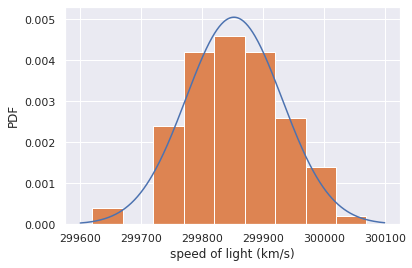

In [121]:
plt.plot(x_s, st.norm.pdf(x_s, c.mean(), c.std(ddof = 1)))
plt.hist(c, bins = 9, density = True)
plt.xlabel('speed of light (km/s)')
plt.ylabel('PDF')
plt.show()

In [122]:
michelson_speed_of_light = df['c'].values

mean = np.mean(michelson_speed_of_light)
std = np.std(michelson_speed_of_light, ddof = 1)

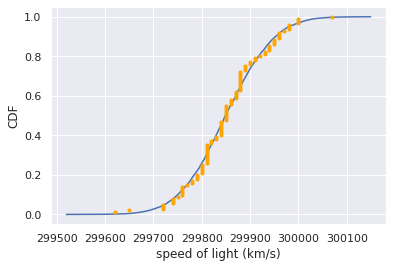

In [124]:
samples = np.random.normal(mean, std, size=10000)

x, y = ecdf(michelson_speed_of_light)

x_theor, y_theor = ecdf(samples)

# Plot data & model (E)CDFs
plt.plot(x_theor, y_theor)
plt.plot(x, y, marker='.', linestyle='none', color = 'orange')
plt.xlabel('speed of light (km/s)')
plt.ylabel('CDF')
plt.show()

## Joint Probability

Verify that $P(A,B)=P(A)P(B)$ in the two fair coin-flip case (A=heads, B=heads)

In [125]:
x_0 = np.random.binomial(2, 0.5, 10000)
x_0

array([0, 0, 2, ..., 0, 1, 1])

In [126]:
x_0.shape

(10000,)

In [127]:
sum(x_0 == 2)

2561

In [129]:
p_ab = sum(x_0 == 2) / len(x_0)
p_ab

0.2561

0.2561


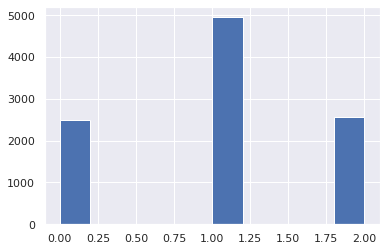

In [136]:
plt.hist(x_0);
print(p_ab)

In [137]:
x_1 = np.random.binomial(1, 0.5, 10000)
x_1

array([1, 1, 1, ..., 0, 1, 0])

In [138]:
p_a = sum(x_1 == 1) / len(x_0)
p_a

0.4978

In [139]:
x_2 = np.random.binomial(1, 0.5, 10000)
x_2

array([1, 1, 0, ..., 0, 1, 1])

In [140]:
p_b = sum(x_2 == 1) / len(x_0)
p_b

0.4924

In [141]:
p_ab_2 = p_a * p_b
p_ab_2

0.24511672

0.24511672


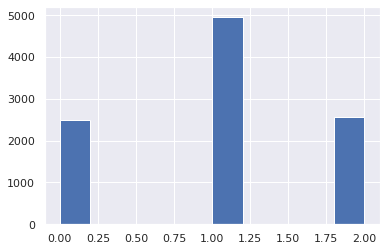

In [142]:
plt.hist(x_0);
print(p_ab_2)

### What is the probability that two randomly selected birds have beak depths over 10?

In [143]:
df_12 = pd.read_csv('finch_beaks_2012.csv')

In [144]:
df_12.head(3)

,band,species,blength,bdepth
0,19022,fortis,10.0,8.5
1,19028,fortis,12.5,8.9
2,19032,fortis,9.3,7.5


In [145]:
df_12.columns

Index(['band', 'species', 'blength', 'bdepth'], dtype='object')

In [146]:
df_12.shape

(249, 4)

In [147]:
lengths = df_12['blength']

In [148]:
lengths > 10

0      False
1       True
2      False
3       True
4       True
       ...  
244     True
245     True
246     True
247     True
248     True
Name: blength, Length: 249, dtype: bool

In [150]:
p_a = (sum(lengths > 10)) / len(lengths)
p_b = (sum(lengths > 10)) / len(lengths)

p_a * p_b

0.724891534007516

In [152]:
n_samples = 100000
np.random.choice(lengths, n_samples, replace = True)

array([ 9.7, 14. , 13.9, ..., 11.1, 13.1, 11. ])

In [153]:
np.random.choice(lengths, n_samples, replace = True).shape

(100000,)

In [154]:
# Calculate P(A)P(B) using resampling methods:

p_a = sum(np.random.choice(lengths, n_samples, replace = True) > 10) / n_samples
p_b = sum(np.random.choice(lengths, n_samples, replace = True) > 10) / n_samples

p_a*p_b

0.7261339880000001

In [155]:
np.random.choice(lengths, (n_samples, 2), replace=True)

array([[ 9.6, 13.1],
       [14.6, 10. ],
       [11.8, 11.5],
       ...,
       [10.2, 10. ],
       [ 9.6, 15.2],
       [14.3, 12.9]])

In [156]:
np.random.choice(lengths, (n_samples, 2), replace=True).shape

(100000, 2)

In [161]:
# Calculate P(A,B) using resampling methods:

samples = np.random.choice(lengths, (n_samples, 2), replace=True)

_ = samples > (10, 10)

print(np.prod(_, axis = 1))

print(np.prod(_, axis = 1).shape)

p_ab = sum(np.prod(_, axis = 1)) / n_samples

p_ab

[1 0 1 ... 1 1 1]
(100000,)


0.72526

## Conditional Probability

Now that we have a grasp on joint probabilities, lets consider conditional probabilities, that is, the probability of some $A$, knowing that some other $B$ is true. We use the notation $P(A|B)$ to denote this. 

For example, you can ask the question "What is the probability of a finch beak having depth $&lt;10$, knowing that the finch is of species 'fortis'?"

In [162]:
sum(df_12['blength'] > 10) / len(df_12)

0.8514056224899599

In [164]:
df_12.columns

Index(['band', 'species', 'blength', 'bdepth'], dtype='object')

In [166]:
df_12['species'].unique()

array(['fortis', 'scandens', 'unknown'], dtype=object)

In [167]:
df_fortis = df_12.loc[df_12['species'] == 'fortis']

sum(df_fortis.blength > 10) / len(df_fortis)

0.6942148760330579

In [168]:
df_scandens = df_12.loc[df_12['species'] == 'scandens']

sum(df_scandens.blength > 10) / len(df_scandens)

1.0

## Joint and conditional probabilities
Conditional and joint probabilites are related by the following: $$ P(A,B) = P(A|B)P(B)$$

**Question: Suppose that a test for using a particular drug is 99% sensitive and 99% specific. That is, the test will produce 99% true positive results for drug users and 99% true negative results for non-drug users. Suppose that 0.5% (5 in 1,000) of people are users of the drug. What is the probability that a randomly selected individual with a positive test is a drug user?**

If we can answer this, it will be really cool as it shows how we can move from knowing $P(+|user)$ to $P(user|+)$, a MVP for being able to move from $P(data|model)$ to $P(model|data)$.

In the spirit of this workshop, it's now time to harness your computational power and the intuition of simulation to solve this drug testing example.

Before doing so, what do you think the answer to the question "What is the probability that a randomly selected individual with a positive test is a drug user?" is? Write down your guess.

In [169]:
# Take 10,000 subjects:

n = 100000

# Sample for number of users, non-users
users = np.random.binomial(n, 0.005, 1) 
non_users = n - users

In [170]:
users

array([479])

In [171]:
non_users

array([99521])

In [174]:
u_pos = np.random.binomial(users, 0.99)

non_u_pos = np.random.binomial(non_users, 0.01)

print(u_pos, non_u_pos)

[477] [1021]


In [175]:
u_pos / (u_pos + non_u_pos)

array([0.31842457])

Discussion: 
1. What you have been able to do here is to solve the following problem: you knew $P(+|user)=0.99$, but you were trying to figure out $P(user|+)$. Is the answer what you expected? If not, why not?

2. Key note: This is related to the serious scientific challenge posed at the beginning here: if you know the underlying parameters/model, you can figure out the distribution and the result, but often we have only the experimental result and we're trying to figure out the most appropriate model and parameters.

It is **Bayes' Theorem** that lets us move between these.

## Bayes' Theorem

$$P(B|A) = \frac{P(A|B)P(B)}{P(A)}$$
As you may have guessed, it is Bayes' Theorem that will allow us to move back and forth between $P(data|model)$ and $P(model|data)$. As we have seen, $P(model|data)$ is usually what we're interested in as data scientists yet $P(data|model)$ is what we can easily compute, either by simulating our model or using analytic equations.

One of the coolest things: Bayes Theorem can be proved with a few lines of mathematics. Your instructor will do this on the chalk/white-board now.

Bayes Theorem solves the above drug testing problem
Bayes Theorem can be used to analytically derive the solution to the 'drug testing' example above as follows.

From Bayes Theorem,

$$P(user|+) = \frac{P(+|user)P(user)}{P(+)}$$
We can expand the denominator here into

$$P(+)  = P(+,user) + P(+,non-user) $$
so that

$$ P(+)=P(+|user)P(user) + P(+|non-user)P(non-user)$$
and

$$P(user|+) = \frac{P(+|user)P(user)}{P(+|user)P(user) + P(+|non-user)P(non-user)}$$
.

Calculating this explicitly yields

$$P(user|+) = \frac{0.99\times 0.005}{0.99\times 0.005 + 0.01\times 0.995} = 0.332 $$

This means that if an individual tests positive, there is still only a 33.2% chance that they are a user! This is because the number of non-users is so high compared to the number of users.

Coming up: from Bayes Theorem to Bayesian Inference!

## From Bayes' Theorem to Bayesian Inference¶
Let's say that we flip a biased coin several times and we want to estimate the probability of heads from the number of heads we saw. Statistical intuition tells us that our best estimate of $p(heads)=$ number of heads divided by total number of flips.

However,

It doesn't tell us how certain we can be of that estimate and
This type of intuition doesn't extend to even slightly more complex examples.
Bayesian inference helps us here. We can calculate the probability of a particular $p=p(H)$ given data $D$ by setting $A$ in Bayes Theorem equal to $p$ and $B$ equal to $D$.

$$P(p|D) = \frac{P(D|p)P(p)}{P(D)} $$
In this equation, we call $P(p)$ the prior (distribution), $P(D|p)$ the likelihood and $P(p|D)$ the posterior (distribution). The intuition behind the nomenclature is as follows: the prior is the distribution containing our knowledge about $p$ prior to the introduction of the data $D$ & the posterior is the distribution containing our knowledge about $p$ after considering the data $D$.

Note that we're overloading the term probability here. In fact, we have 3 distinct usages of the word:

The probability $p$ of seeing a head when flipping a coin;
The resulting binomial probability distribution $P(D|p)$ of seeing the data $D$, given $p$;
The prior & posterior probability distributions of $p$, encoding our uncertainty about the value of $p$.
Key concept: We only need to know the posterior distribution $P(p|D)$ up to multiplication by a constant at the moment: this is because we really only care about the values of $P(p|D)$ relative to each other – for example, what is the most likely value of $p$? To answer such questions, we only need to know what $P(p|D)$ is proportional to, as a function of $p$. Thus we don’t currently need to worry about the term $P(D)$. In fact,

$$P(p|D) \propto P(D|p)P(p) $$
Note: What is the prior? Really, what do we know about $p$ before we see any data? Well, as it is a probability, we know that $0\leq p \leq1$. If we haven’t flipped any coins yet, we don’t know much else: so it seems logical that all values of $p$ within this interval are equally likely, i.e., $P(p)=1$, for $0\leq p \leq1$. This is known as an uninformative prior because it contains little information (there are other uninformative priors we may use in this situation, such as the Jeffreys prior, to be discussed later). People who like to hate on Bayesian inference tend to claim that the need to choose a prior makes Bayesian methods somewhat arbitrary, but as we’ll now see, if you have enough data, the likelihood dominates over the prior and the latter doesn’t matter so much.

Essential remark: we get the whole distribution of $P(p|D)$, not merely a point estimate plus errors bars, such as 95% confidence intervals.

## Bayesian parameter estimation I: flip those coins¶
Now let's generate some coin flips and try to estimate $p(H)$. Two notes:

given data $D$ consisting of $n$ coin tosses & $k$ heads, the likelihood function is given by $L:=P(D|p) \propto p^k(1-p)^{n-k}$;
given a uniform prior, the posterior is proportional to the likelihood.

In [177]:
def plot_posterior(p = 0.6, N = 0):
    """Plot the posterior given a uniform prior; Bernoulli trials
    with probability p; sample size N"""
    
    np.random.seed(42)                                                   # set seed

    n_successes = np.random.binomial(N, p)                               # flip coins 
    
    x = np.linspace(0, 1, 100)                                           # X-axis for PDF
    
    prior = np.ones(len(x))                                              # write out equation for uniform prior
    
    posterior = (x**n_successes) * ((1-x)**(N-n_successes)) * prior      # write out equation for posterior, which is likelihood * prior.
    
    posterior /= np.max(posterior)                                       # pseudo-normalize the posterior so that we can compare them on the same scale.
    
    plt.plot(x, posterior)                                               # plot posterior
    plt.show()

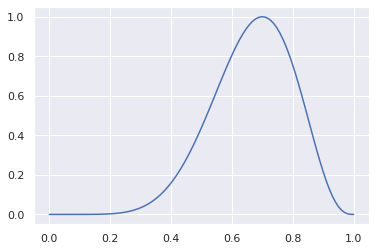

In [178]:
plot_posterior(N = 10)

In [180]:
from ipywidgets import interact

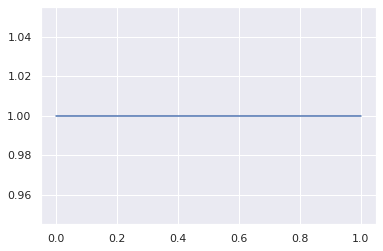

In [194]:
interact(plot_posterior, p = (1, 1, 0.01), N = (0, 1500));

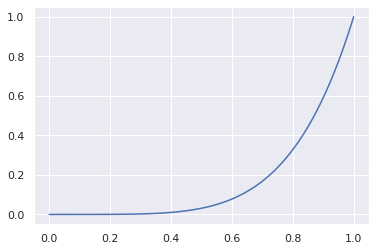

In [199]:
interact(plot_posterior, p = (1, 1, 0.01), N = (5, 1500));

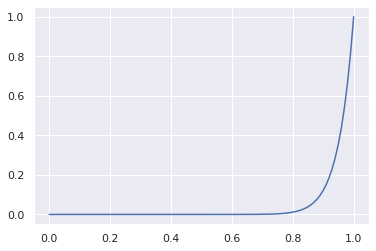

In [204]:
interact(plot_posterior, p = (1, 1, 0.01), N = (20, 1500));

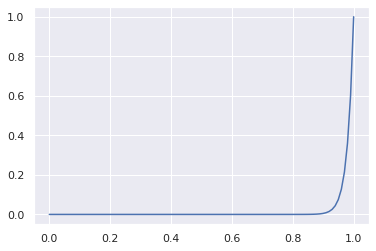

In [205]:
interact(plot_posterior, p = (1, 1, 0.01), N = (50, 1500));

## The choice of the prior¶
You may have noticed that we needed to choose a prior and that, in the small to medium data limit, this choice can affect the posterior. We'll briefly introduce several types of priors and then you'll use one of them for the example above to see the effect of the prior:

Informative priors express specific, definite information about a variable, for example, if we got a coin from the mint, we may use an informative prior with a peak at $p=0.5$ and small variance.
Weakly informative priors express partial information about a variable, such as a peak at $p=0.5$ (if we have no reason to believe the coin is biased), with a larger variance.
Uninformative priors express no information about a variable, except what we know for sure, such as knowing that $0\leq p \leq1$.
Now you may think that the uniform distribution is uninformative, however, what if I am thinking about this question in terms of the probability $p$ and Eric Ma is thinking about it in terms of the odds ratio $r=\frac{p}{1-p}$? Eric rightly feels that he has no prior knowledge as to what this $r$ is and thus chooses the uniform prior on $r$.

With a bit of algebra (transformation of variables), we can show that choosing the uniform prior on $p$ amounts to choosing a decidedly non-uniform prior on $r$ and vice versa. So Eric and I have actually chosen different priors, using the same philosophy. How do we avoid this happening? Enter the Jeffreys prior, which is an uninformative prior that solves this problem. You can read more about the Jeffreys prior here & in your favourite Bayesian text book (Sivia gives a nice treatment).

In the binomial (coin flip) case, the Jeffreys prior is given by $P(p) = \frac{1}{\sqrt{p(1-p)}}$.

In [200]:
def plot_posteriors(p=0.6, N=0):
    
    np.random.seed(42)
    n_successes = np.random.binomial(N, p)
    x = np.linspace(0.01, 0.99, 100)

    likelihood = x**n_successes*(1-x)**(N-n_successes)               # write out the likelihood for the data
    
    prior_uniform = np.ones(len(x))                                  # write out equation for posterior given uniform prior
    
    posterior_uniform = likelihood * prior_uniform
    posterior_uniform /= np.max(posterior_uniform)
    plt.plot(x, posterior_uniform, label = 'Uniform prior')
    
    prior_jeffreys = np.sqrt(x*(1-x))**(-1)                          # write out equation for posterior given Jeffreys prior
    posterior_jeffreys = likelihood * prior_jeffreys
    posterior_jeffreys /= np.max(posterior_jeffreys)
    plt.plot(x, posterior_jeffreys, label='Jeffreys prior')
    plt.legend()
    plt.show()

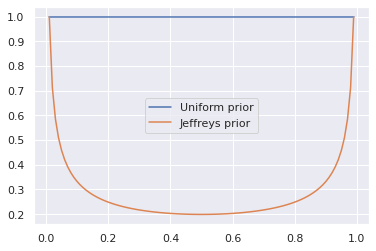

In [201]:
interact(plot_posteriors, p=(0, 1, 0.01), N=(0, 100));

## Bayesian parameter estimation using PyMC3

To completely specify the model in terms of probability distributions. This includes specifying
what the form of the sampling distribution of the data is and
what form describes our uncertainty in the unknown parameters (This formulation is adapted from Fonnesbeck's workshop(https://github.com/fonnesbeck/intro_stat_modeling_2017/blob/master/notebooks/2.%20Basic%20Bayesian%20Inference.ipynb) as Chris said it so well there).
Calculate the posterior distribution.
In the above, the form of the sampling distribution of the data was Binomial (described by the likelihood) and the uncertainty around the unknown parameter $p$ captured by the prior.

Now it is time to do the same using the probabilistic programming language PyMC3. There's loads of cool stuff about PyMC3 and this paradigm, two of which are

1. probabililty distributions are first class citizens, in that we can assign them to variables and use them intuitively to mirror how we think about priors, likelihoods & posteriors.
PyMC3 calculates the posterior for us: this is fancy math done for lazy programmers!
Under the hood, PyMC3 will compute the posterior using a sampling based approach called Markov Chain Monte Carlo (MCMC) or Variational Inference. Check the PyMC3 docs(https://docs.pymc.io/) for more on these.

2. From this notebook onwards, we have prepared a series of examples that will show you how to perform inference and prediction in a variety of problems. Hopefully, you will see that at the end of the day, everything we do boils down to estimation of some kind, and by doing it in a Bayesian setting, we avoid many pitfalls that come from blindly following canned statistical procedures.

### Example: Click-Through Rates
A common experiment in tech data science is to test a product change and see how it affects a metric that you're interested in. Say that I don't think enough people are clicking a button on my website & I hypothesize that it's because the button is a similar color to the background of the page. Then I can set up two pages and send some people to each: the first the original page, the second a page that is identical, except that it has a button that is of higher contrast and see if more people click through. This is commonly referred to as an A/B test and the metric of interest is click-through rate (CTR), what proportion of people click through. Before even looking at two rates, let's use PyMC3 to estimate one.

First generate click-through data, given a CTR $p_a=0.15$.

In [232]:
p_a = 0.15
N = 150
n_successes_a = np.sum(np.random.binomial(N, p_a))

Now it's time to build your probability model. Noticing that our model of having a constant CTR resulting in click or not is a biased coin flip,

1. the sampling distribution is binomial and we need to encode this in the likelihood;
2. there is a single parameter $p$ that we need to describe the uncertainty around, using a prior and we'll use a uniform prior for this.


These are the ingredients for the model so let's now build it:

In [233]:
# Build model of p_a
with pm.Model() as Model:
    # Prior on p
    prob = pm.Uniform('p')
    # Binomial Likelihood
    y = pm.Binomial('y', n=N, p=prob, observed=n_successes_a)

It's now time to sample from the posterior using PyMC3. You'll also plot the posterior:

In [234]:
with Model:
    samples = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:00<00:00, 2983.95it/s]


/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


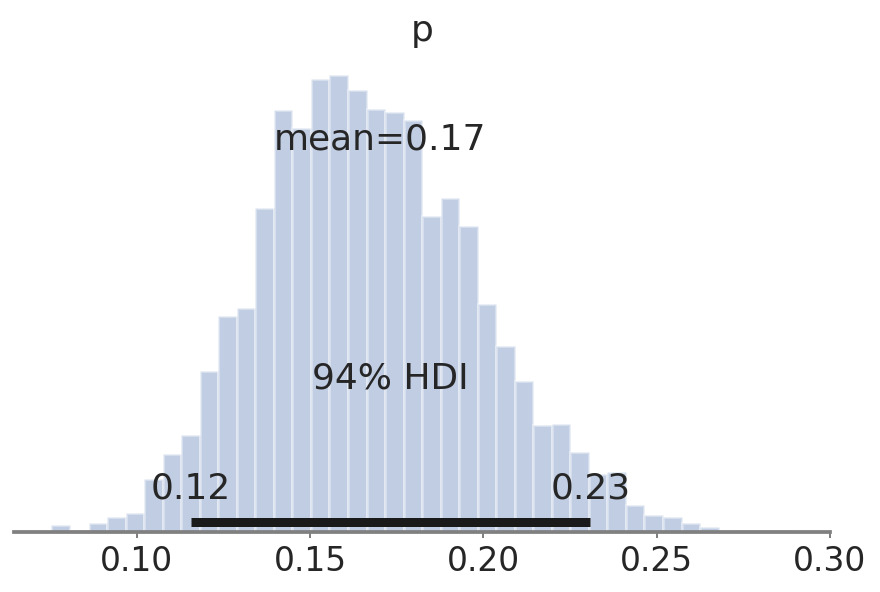

In [235]:
az.plot_posterior(samples, kind='hist');

### Parameter estimation II -- the mean of a population

In this exercise, you'll calculate the posterior mean beak depth of Galapagos finches in a given species

In [236]:
df_12 = pd.read_csv('finch_beaks_2012.csv')
df_fortis = df_12.loc[df_12['species'] == 'fortis']
df_scandens = df_12.loc[df_12['species'] == 'scandens']

To specify the full probability model, you need

1. a likelihood function for the data &
2. priors for all unknowns.

What is the likelihood here? Let's plot the measurements below and see that they look approximately Gaussian/normal so you'll use a normal likelihood $y_i\sim \mathcal{N}(\mu, \sigma^2)$. The unknowns here are the mean $\mu$ and standard deviation $\sigma$ and we'll use weakly informative priors on both

1. a normal prior for $\mu$ with mean $10$ and standard deviation $5$;
2. a uniform prior for $\sigma$ bounded between $0$ and $10$.


We can discuss biological reasons for these priors also but you can also test that the posteriors are relatively robust to the choice of prior here due to the amount of data.

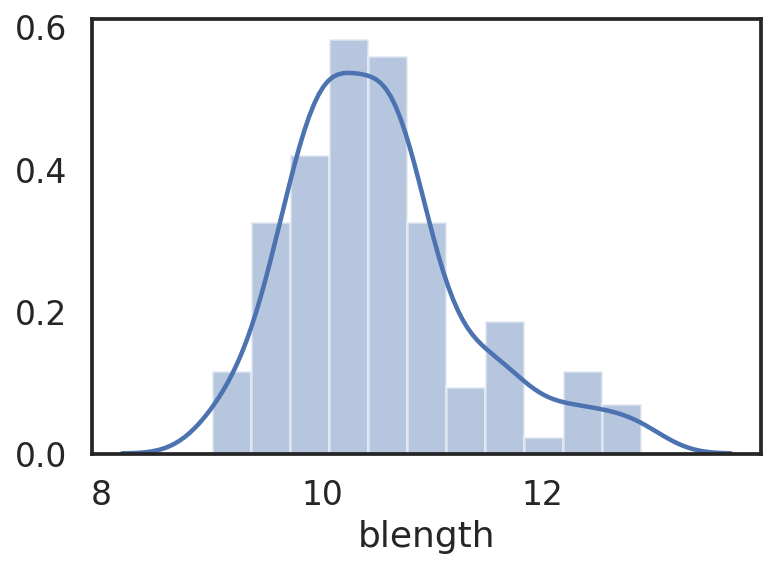

In [242]:
sns.distplot(df_fortis['blength']);

In [238]:
with pm.Model() as model:
    # Prior for mean & standard deviation
    μ_1 = pm.Normal('μ_1', mu=10, sd=5)
    σ_1 = pm.Lognormal('σ_1', 0, 10)
    # Gaussian Likelihood
    y_1 = pm.Normal('y_1', mu=μ_1, sd=σ_1, observed=df_fortis['blength'])

In [239]:
with model:
    samples = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ_1, μ_1]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:01<00:00, 1994.17it/s]


/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'μ_1'}>,
       <AxesSubplot:title={'center':'σ_1'}>], dtype=object)

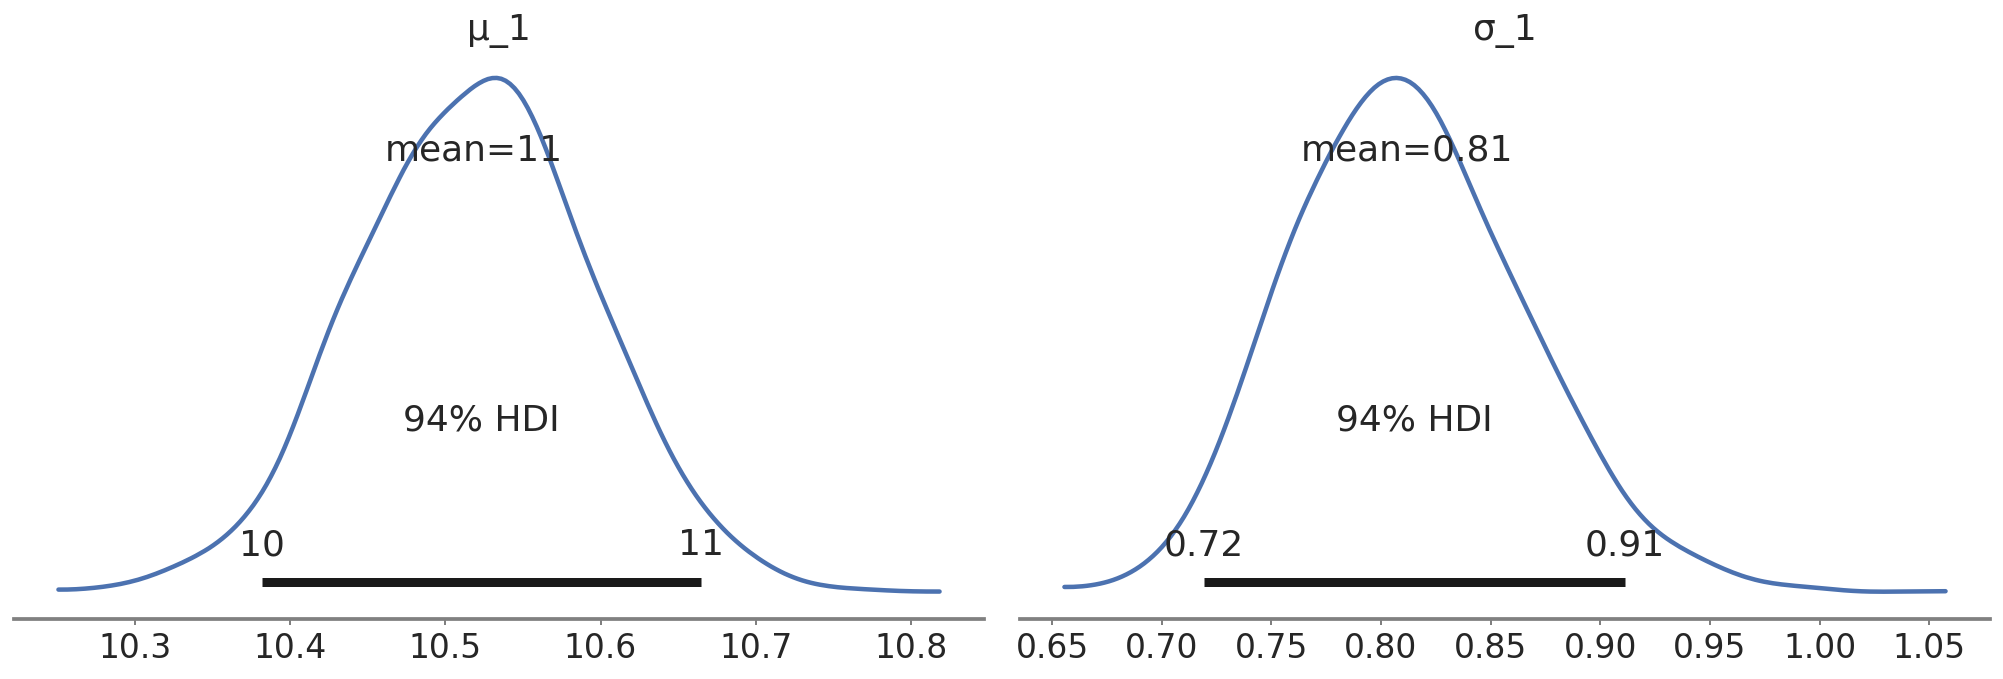

In [240]:
az.plot_posterior(samples)

## Bayesian Hypothesis testing

Bayesian Hypothesis testing I: A/B tests on click through rates
Assume we have a website and want to redesign the layout (A) and test whether the new layout (B) results in a higher click through rate. When people come to our website we randomly show them layout A or B and see how many people click through for each. First let's generate the data we need:

In [244]:
# click-through rates
p_a = 0.15
p_b = 0.20
N = 1000
n_successes_a = np.sum(np.random.uniform(size=N) <= p_a)
n_successes_b = np.sum(np.random.uniform(size=N) <= p_b)

Once again, we need to specify our models for $p_a$ and $p_b$. Each will be the same as the CTR example above

1. Binomial likelihoods
2. uniform priors on $p_a$ and $_p$.

We also want to calculate the posterior of the difference $p_a-p_b$ and we do so using pm.Deterministic(), which specifies a deterministic random variable, i.e., one that is completely determined by the values it references, in the case $p_a$ & $p_b$.

We'll now build the model:

In [246]:
with pm.Model() as Model:
    # Prior on p
    prob_a = pm.Uniform('p_a')
    prob_b = pm.Uniform('p_b')
    # Binomial Likelihood
    y_a = pm.Binomial('y_a', n=N, p=prob_a, observed=n_successes_a)
    y_b = pm.Binomial('y_b', n=N, p=prob_b, observed=n_successes_b)
    diff_clicks = pm.Deterministic('diff_clicks', prob_a-prob_b)

Sample from the posterior and plot them:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_b, p_a]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:01<00:00, 2202.76it/s]
/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


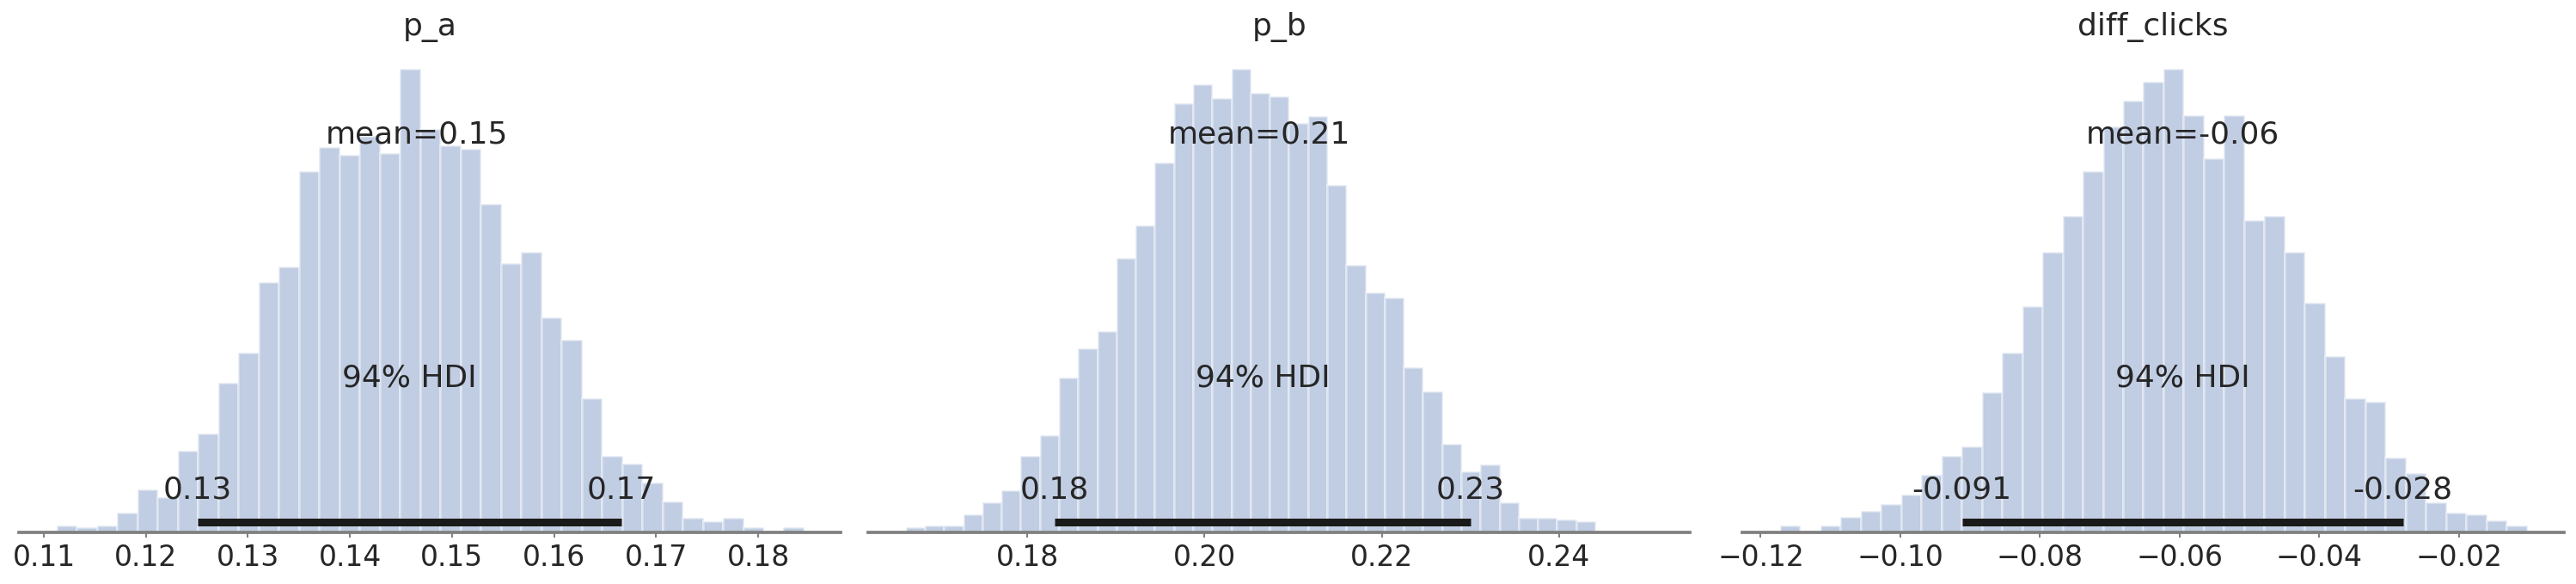

In [247]:
with Model:
    samples = pm.sample(2000)
az.plot_posterior(samples, kind='hist');

### Bayesian Hypothesis testing II -- beak lengths difference between species

Task: Determine whether the mean beak length of the Galapogas finches differs between species. For the mean of each species, use the same model as in previous hand-on section:

1. Gaussian likelihood;
2. Normal prior for the means;
3. Uniform prior for the variances.

Also calculate the difference between the means and, for bonus points, the effect size, which is the difference between the means divided by the pooled standard deviations = $\sqrt{(\sigma_1^2+\sigma_2^2)/2}$.

Don't forget to sample from the posteriors and plot them!

In [248]:
with pm.Model() as model:
    # Priors for means and variances
    μ_1 = pm.Normal('μ_1', mu=10, sd=5)
    σ_1 = pm.Uniform('σ_1', 0, 10)
    μ_2 = pm.Normal('μ_2', mu=10, sd=5)
    σ_2 = pm.Uniform('σ_2', 0, 10)
    # Gaussian Likelihoods
    y_1 = pm.Normal('y_1', mu=μ_1, sd=σ_1, observed=df_fortis['blength'])
    y_2 = pm.Normal('y_2', mu=μ_2, sd=σ_2, observed=df_scandens['blength'])
    # Calculate the effect size and its uncertainty.
    diff_means = pm.Deterministic('diff_means', μ_1 - μ_2)
    pooled_sd = pm.Deterministic('pooled_sd', 
                                 np.sqrt(np.power(σ_1, 2) + 
                                         np.power(σ_2, 2)) / 2)
    effect_size = pm.Deterministic('effect_size', 
                                   diff_means / pooled_sd)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ_2, μ_2, σ_1, μ_1]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [00:01<00:00, 1508.62it/s]
/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


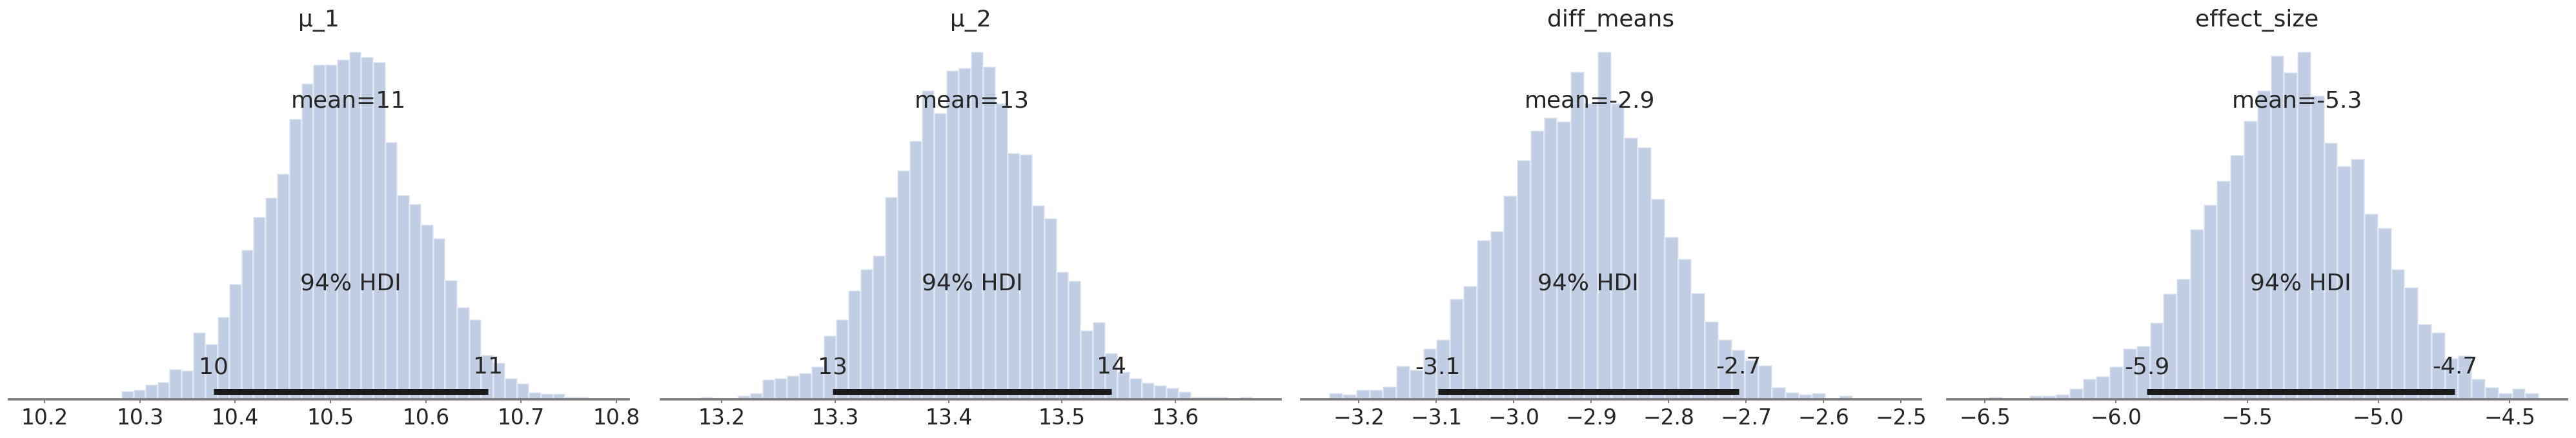

In [249]:
with model:
    samples = pm.sample(2000)
az.plot_posterior(samples, var_names=['μ_1', 'μ_2', 'diff_means', 'effect_size'], kind='hist');